In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
path = "./dataset.txt"
df = pd.read_csv(path)
df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [7]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: 3.145186
p-value: 1.000000


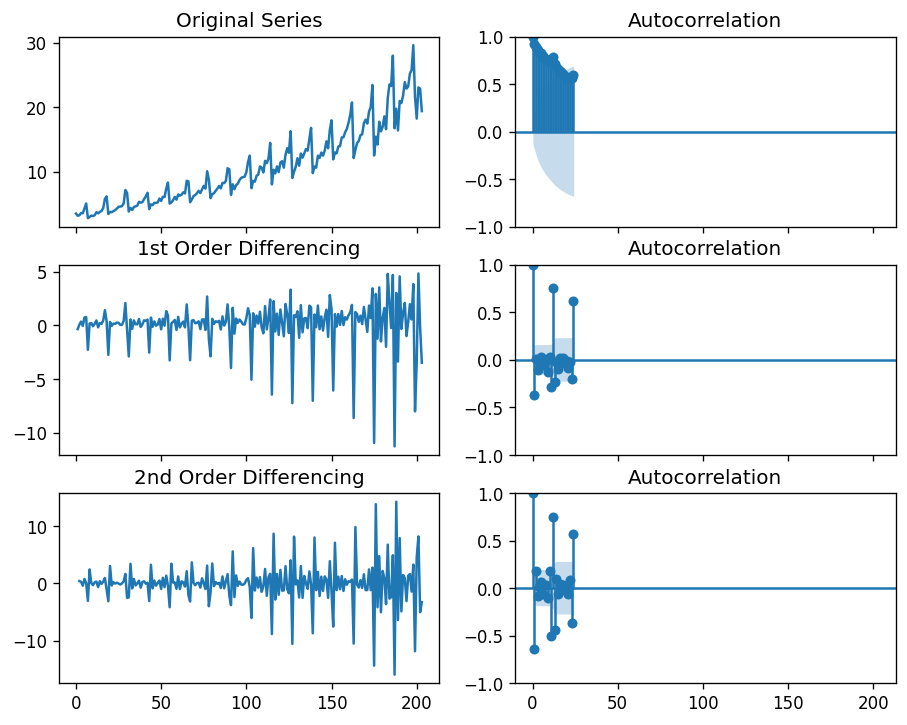

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()


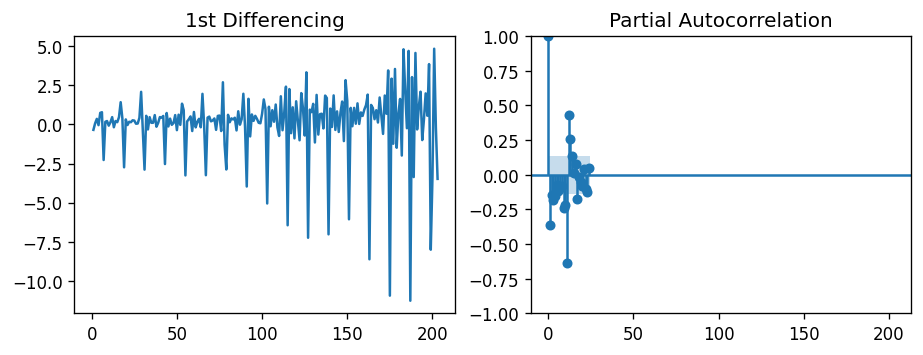

In [9]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()


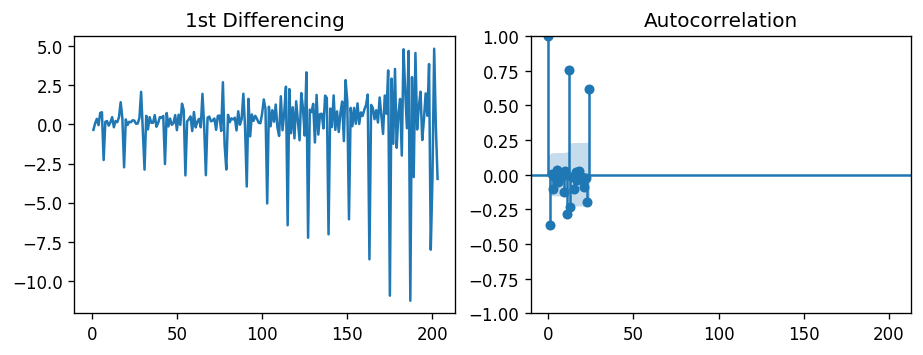

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()


In [11]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model (1,1,2)
model = ARIMA(df['value'], order=(1, 1, 2))
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -424.570
Date:                Sat, 05 Jul 2025   AIC                            857.140
Time:                        13:59:20   BIC                            870.393
Sample:                             0   HQIC                           862.502
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4178      0.356      1.174      0.240      -0.280       1.115
ma.L1         -0.9546      0.377     -2.531      0.011      -1.694      -0.215
ma.L2          0.0969      0.272      0.356      0.7

In [12]:
# 1,1,1 ARIMA Model
model = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit(method_kwargs={"options": {"disp": True}})
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -424.762
Date:                Sat, 05 Jul 2025   AIC                            855.524
Time:                        13:59:27   BIC                            865.463
Sample:                             0   HQIC                           859.545
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3009      0.094      3.195      0.001       0.116       0.485
ma.L1         -0.8300      0.048    -17.204      0.000      -0.925      -0.735
sigma2         3.8327      0.259     14.790      0.0

C:\Users\rohil\dataScience\timeseries\Lib\site-packages\statsmodels\base\optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: options. After release 0.14, this will raise.
  warnings.warn(


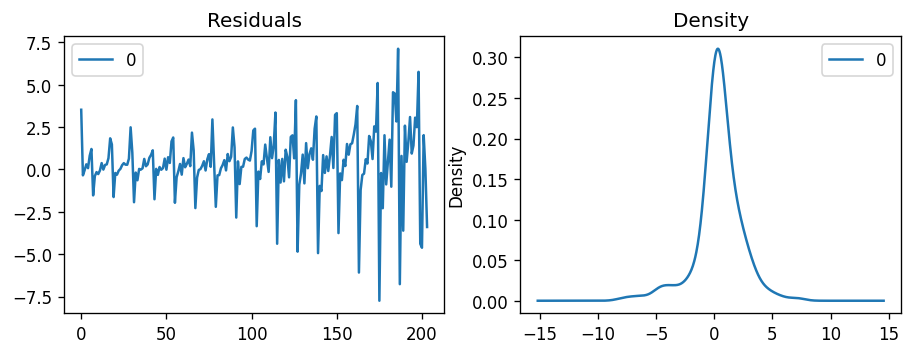

In [13]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

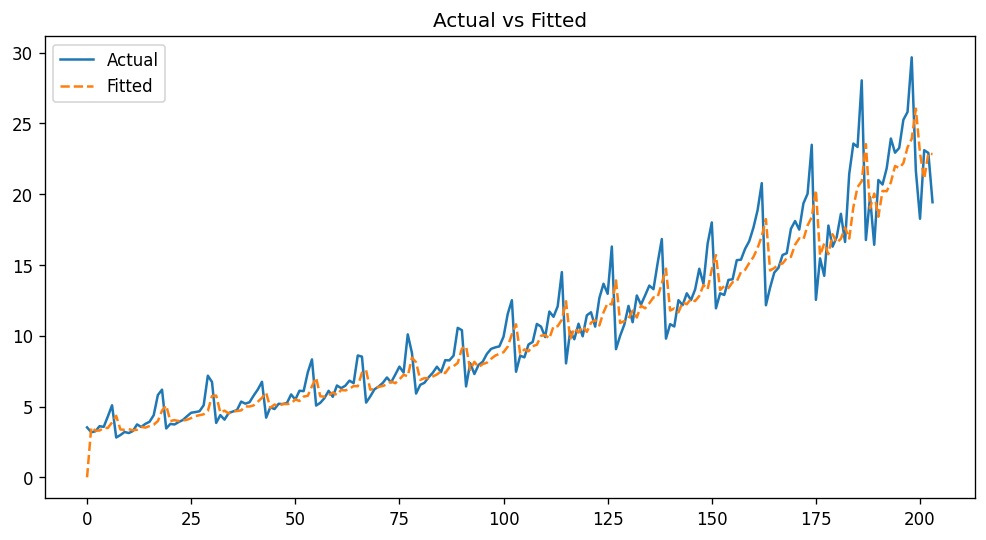

In [14]:
# Generate predictions (in-sample)
pred = model_fit.predict(start=0, end=len(df)-1)

# Plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(df['value'], label='Actual')
plt.plot(pred, label='Fitted', linestyle='--')
plt.title('Actual vs Fitted')
plt.legend()
plt.show()


In [15]:
# Find the optimal ARIMA model using Out-of-Time Cross validation
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df.value[:85]
test = df.value[85:]

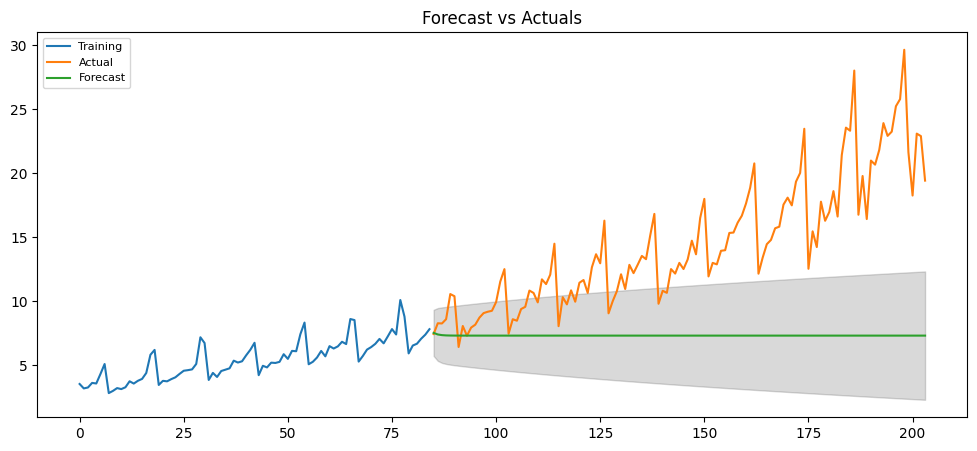

In [16]:
# Fit the model
model = ARIMA(train, order=(1, 1, 1))
fitted = model.fit()

# Forecast
n_periods = len(test)
forecast_result = fitted.get_forecast(steps=n_periods)

# Extract predicted mean and confidence intervals
fc_series = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Create lower and upper series
lower_series = conf_int.iloc[:, 0]
upper_series = conf_int.iloc[:, 1]

# Align indices
fc_series.index = test.index
lower_series.index = test.index
upper_series.index = test.index

# Plot
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(train, label='Training')
plt.plot(test, label='Actual')
plt.plot(fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   85
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -116.886
Date:                Sat, 05 Jul 2025   AIC                            243.771
Time:                        14:00:01   BIC                            255.865
Sample:                             0   HQIC                           248.630
                                 - 85                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2204      0.194     -1.138      0.255      -0.600       0.159
ar.L2         -0.3436      0.141     -2.443      0.015      -0.619      -0.068
ar.L3         -0.0934      0.252     -0.370      0.7

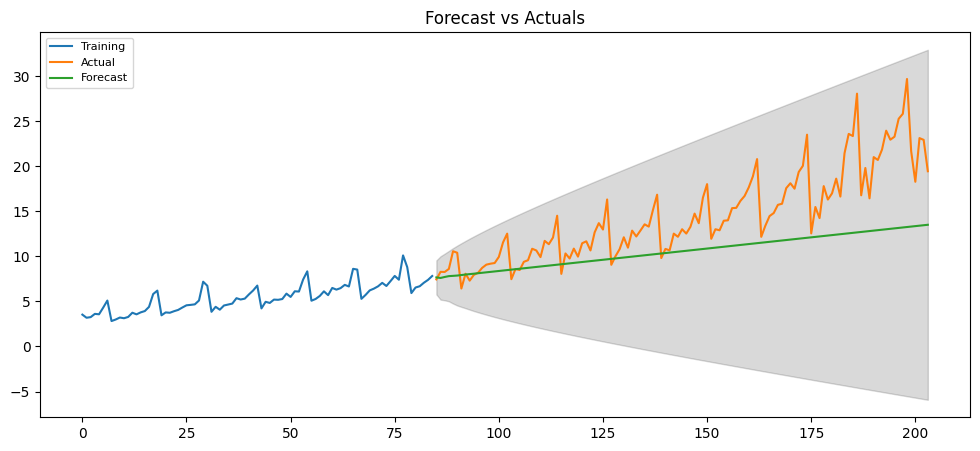

In [17]:
# Build the ARIMA model
model = ARIMA(train, order=(3, 2, 1))
fitted = model.fit()
print(fitted.summary())

# Forecast the next 119 periods
forecast_result = fitted.get_forecast(steps=119)

# Extract predicted mean and confidence intervals
fc_series = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Align forecast to test set index
fc_series.index = test.index
conf_int.index = test.index
lower_series = conf_int.iloc[:, 0]
upper_series = conf_int.iloc[:, 1]

# Plot forecast vs actuals
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='Training')
plt.plot(test, label='Actual')
plt.plot(fc_series, label='Forecast')
plt.fill_between(test.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [18]:
def forecast_accuracy(forecast, actual):
    forecast = np.array(forecast)
    actual = np.array(actual)

    # Avoid divide-by-zero warnings
    non_zero_actual = actual != 0
    safe_actual = actual[non_zero_actual]
    safe_forecast = forecast[non_zero_actual]

    mape = np.mean(np.abs(safe_forecast - safe_actual) / np.abs(safe_actual)) if len(safe_actual) > 0 else np.nan
    me = np.mean(forecast - actual)
    mae = np.mean(np.abs(forecast - actual))
    mpe = np.mean((safe_forecast - safe_actual) / safe_actual) if len(safe_actual) > 0 else np.nan
    rmse = np.sqrt(np.mean((forecast - actual) ** 2))
    corr = np.corrcoef(forecast, actual)[0, 1] if len(forecast) > 1 else np.nan

    # Min-max
    stacked = np.hstack([forecast.reshape(-1, 1), actual.reshape(-1, 1)])
    mins = np.min(stacked, axis=1)
    maxs = np.max(stacked, axis=1)
    minmax = 1 - np.mean(mins / maxs)

    # ACF1 of forecast error
    residuals = forecast - actual
    acf1 = acf(residuals, nlags=1)[1] if len(residuals) > 1 else np.nan

    return {
        'mape': mape,
        'me': me,
        'mae': mae,
        'mpe': mpe,
        'rmse': rmse,
        'acf1': acf1,
        'corr': corr,
        'minmax': minmax
    }

metrics = forecast_accuracy(fc_series, test.values)
for k, v in metrics.items():
    print(f"{k.upper()}: {v:.4f}")

MAPE: 0.2327
ME: -3.8805
MAE: 3.9815
MPE: -0.2193
RMSE: 5.3070
ACF1: 0.6960
CORR: 0.8737
MINMAX: 0.2319


In [19]:
import pmdarima as pm
import pandas as pd

df = pd.read_csv("./dataset.txt")  # Replace with actual path
model = pm.auto_arima(df['value'], 
                      start_p=1, start_q=1,
                      test='adf',
                      max_p=3, max_q=3,
                      m=1,
                      d=None,
                      seasonal=False,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=874.416, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1602.665, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=913.571, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1392.713, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=865.809, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=867.147, Time=0.19 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=871.437, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=868.483, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=858.292, Time=0.27 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=859.374, Time=0.28 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=860.867, Time=0.38 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total fit 

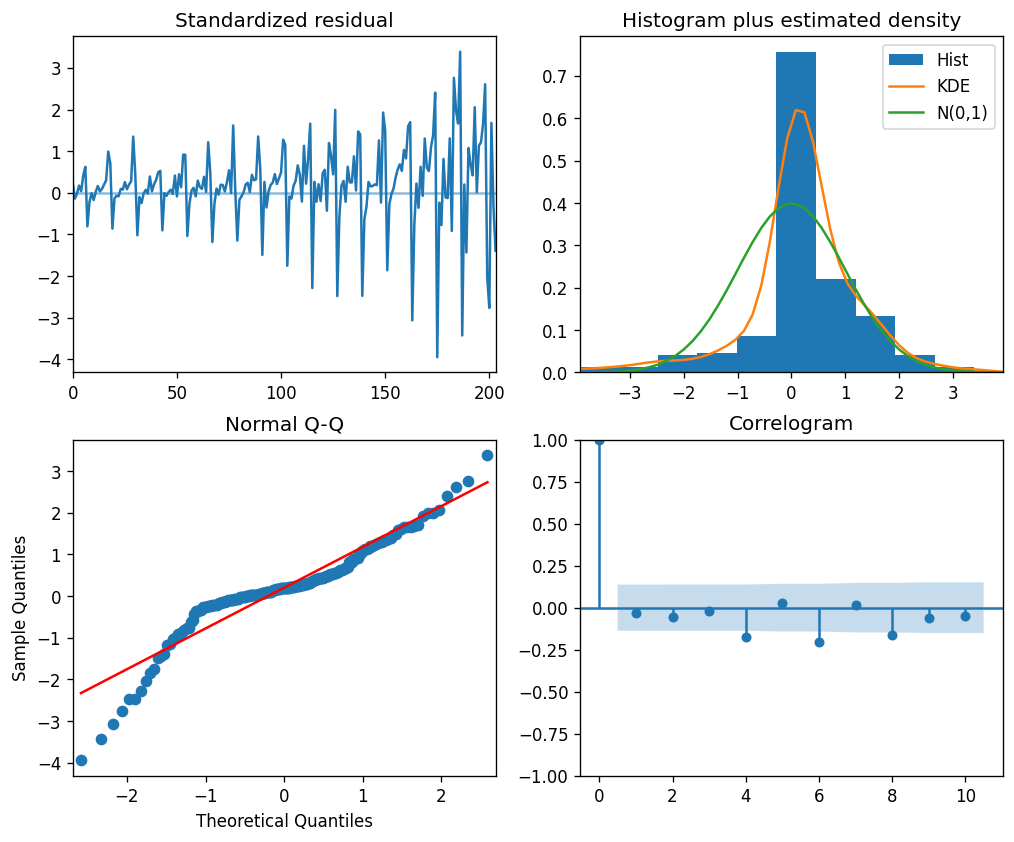

In [20]:
#How to interpret the residual plots in ARIMA model
model.plot_diagnostics(figsize=(10,8))
plt.show()

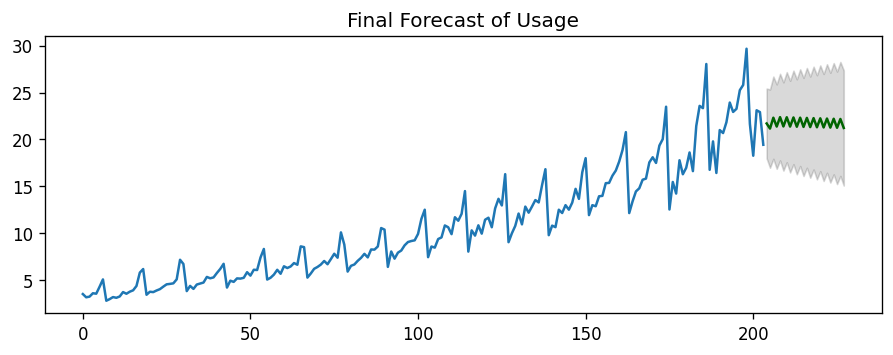

In [21]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k', alpha=.15)

plt.title("Final Forecast of Usage")
plt.show()

SARIMA model in python

In [22]:
data = pd.read_csv('./dataset.txt', parse_dates=['date'], index_col='date')

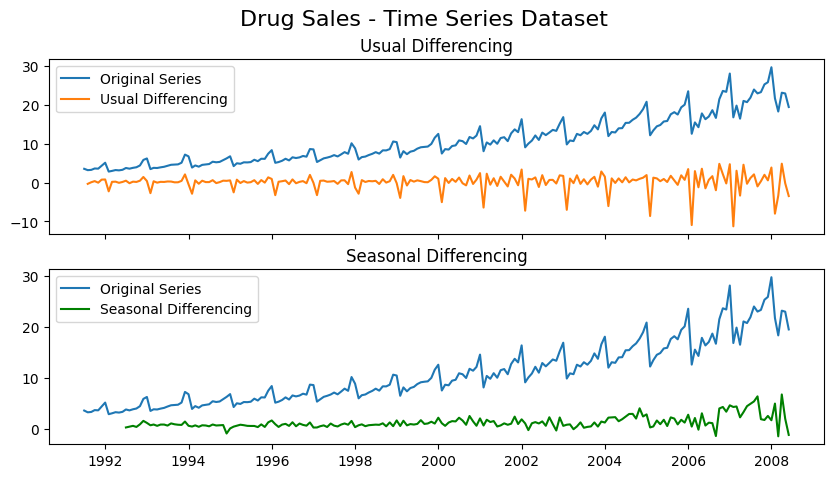

In [23]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Differencing
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Drug Sales - Time Series Dataset', fontsize=16)
plt.show()

In [24]:
# !pip3 install pyramid-arima (already done)
# import pmdarima as pm
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=534.818, Time=0.67 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=624.061, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=596.068, Time=0.26 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=611.475, Time=0.19 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=757.274, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=559.407, Time=0.15 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=536.817, Time=2.21 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=543.106, Time=0.70 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=537.801, Time=2.81 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=594.467, Time=0.17 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=529.829, Time=0.68 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=555.198, Time=0.17 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.41 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(1, 0, 2)x(1, 1, 2, 12)   Log Likelihood                -253.985
Date:                            Sat, 05 Jul 2025   AIC                            523.970
Time:                                    14:08:34   BIC                            550.030
Sample:                                07-01-1991   HQIC                           534.525
                                     - 06-01-2008                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0056      0.010      0.585      0.558      -0.013       0.024
ar.L1          0.9753      0.019     51.774      0.000       0.938       1.012
ma.L1         -0.9040      0.057    -15.837      0.000      -1.016      -0.792
ma.L2          0.2172      0.059      3.708      0.000       0.102       0.332
ar.S.L12       0.8372      0.167      5.002      0.000       0.509       1.165
ma.S.L12      -1.5613      0.185     -8.418      0.000      -1.925      -1.198
ma.S.L24       0.7413      0.112      6.623      0.000       0.522       0.961
sigma2         0.7591      0.065     11.674      0.000       0.632       0.887
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):               143.76
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):              14.36   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k', alpha=.15)

plt.title("ARIMA - Final Forecast of Drug Sales - Time Series Dataset")
plt.show()

NameError: name 'smodel' is not defined

In [26]:
# SARIMAX model with exogeneous variables
# Compute Seasonal Index
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# multiplicative seasonal component
result_mul = seasonal_decompose(data['value'][-36:],   # 3 years
                                model='multiplicative',
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# merge with the base data
data['month'] = data.index.month
df = pd.merge(data, seasonal_index, how='left', on='month')
df.columns = ['value', 'month', 'seasonal_index']
df.index = data.index  # reassign the index

In [27]:
import pmdarima as pm

# SARIMAX Model
sxmodel = pm.auto_arima(df[['value']], exogenous=df[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=534.818, Time=0.66 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=624.061, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=596.068, Time=0.24 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=611.475, Time=0.21 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=757.274, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=559.407, Time=0.17 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=536.817, Time=2.21 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=543.106, Time=0.75 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=537.801, Time=2.76 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=594.467, Time=0.17 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=529.829, Time=0.68 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=555.198, Time=0.19 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.43 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(1, 0, 2)x(1, 1, 2, 12)   Log Likelihood                -253.985
Date:                            Sat, 05 Jul 2025   AIC                            523.970
Time:                                    14:10:05   BIC                            550.030
Sample:                                07-01-1991   HQIC                           534.525
                                     - 06-01-2008                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0056      0.010      0.585      0.558      -0.013       0.024
ar.L1          0.9753      0.019     51.774      0.000       0.938       1.012
ma.L1         -0.9040      0.057    -15.837      0.000      -1.016      -0.792
ma.L2          0.2172      0.059      3.708      0.000       0.102       0.332
ar.S.L12       0.8372      0.167      5.002      0.000       0.509       1.165
ma.S.L12      -1.5613      0.185     -8.418      0.000      -1.925      -1.198
ma.S.L24       0.7413      0.112      6.623      0.000       0.522       0.961
sigma2         0.7591      0.065     11.674      0.000       0.632       0.887
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):               143.76
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):              14.36   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

End